In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters
beta = 3.5
sdim = 128

In [3]:
# Set Seed
np.random.seed(117);

In [4]:
# Build power spectrum 
f = [x/sdim for x in range(1, int(sdim/2)+1)] + [x/sdim for x in range(-int(sdim/2), 0)]
u = np.reshape(f, (sdim, 1))
v = np.reshape(f, (1, sdim))
w = np.reshape(f, (sdim, 1, 1))
pattern = (u**2 + v**2 + w**2)**(-beta/2)

In [5]:
# Noise and ifft
phases = np.random.normal(0, 255, size=[sdim, sdim, sdim]);
pattern = np.fft.ifftn(pattern**0.5 * (np.cos(2*np.pi*phases)+1j*np.sin(2*np.pi*phases)))

In [6]:
# Normalize result
pattern = np.real(pattern)
pattern = (pattern-np.amin(pattern))/np.amax(pattern-np.amin(pattern))

In [7]:
# Binarize result for box counting
threshold, upper, lower = 0.5, 1, 0
pattern = np.asarray(np.where(pattern>threshold, upper, lower))

In [8]:
height = sdim+1
# Get subdivision sizes
n = 2**np.floor(np.log(height)/np.log(2))  # Greatest power of 2 less than or equal to canvas
# Extract the exponent
n = int(np.log(n)/np.log(2))
boxes = 2**np.arange(n-1, 0, -1)
boxcounts = {box: 0 for box in boxes}  # Dictionary to store counts for each box size

In [9]:
def boxcount3d(sizes, save=False, visualize=False):
    for s in sizes:

        # Reset box counter
        bc = 0

        # Make list of box corners
        corners = []
        for z in range(0, height, int(height/s)):
            for y in range(0, height, int(height/s)):
                for x in range(0, height, int(height/s)):
                    corners.append([x, y, z])


        # Detect edges and draw box
        for c in range(1, len(corners)-s**3):
            boxval = np.mean(pattern[corners[c-1][0]:corners[c][0], corners[c-1][1]:corners[c+s][1], corners[c-1][2]:corners[c+s**3][2]])
            if 0.0 < boxval < 1.0:
                bc += 1

        boxcounts[s] = bc

    x = [x for x in boxcounts.keys()]
    y = [y for y in boxcounts.values()]

    m, b = np.polyfit(np.log(x), np.log(y), 1)
    
    return m, boxcounts

In [10]:
s = 2

corners = []
for z in range(0, height, int(height/s)):
    for y in range(0, height, int(height/s)):
        for x in range(0, height, int(height/s)):
            corners.append([x, y, z])

#c = 5

#print(len(corners))

#print(corners[c-1][0], corners[c][0])
#print(corners[c-1][1], corners[c+s][1])
#print(corners[c-1][2], corners[c+s**3][2])

In [20]:
def boxcount2d(sizes, image):
    for s in sizes:

        # Reset box counter
        bc = 0

        # Make list of box corners
        corners = []
        for y in range(0, height, int(height/s)):
            for x in range(0, height, int(height/s)):
                corners.append([x, y])

        # Detect edges and draw box
        for c in range(1, len(corners)-s):
            boxval = np.mean(image[corners[c-1][1]:corners[c+s][1], corners[c-1][0]:corners[c][0]]) #wraparound is causing nans
            #print(boxval)
            if 0.0 < boxval < 1.0:
                bc += 1

        boxcounts[s] = bc

    x = [x for x in boxcounts.keys()]
    y = [y for y in boxcounts.values()]

    m, b = np.polyfit(np.log(x), np.log(y), 1)

    return m, boxcounts

In [12]:
boxcount3d(boxes)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(2.1031825899841525, {64: 12160, 32: 3008, 16: 736, 8: 176, 4: 40, 2: 8})

In [ ]:
slope2d, counts = boxcount2d(boxes, pattern[-1,:,:])

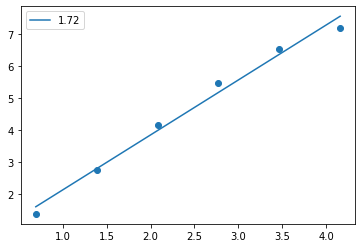

In [16]:
# Get slope and plot
x = [x for x in counts.keys()]
y = [y for y in counts.values()]

m, b = np.polyfit(np.log(x), np.log(y), 1)

plt.plot(np.log(x), m*np.log(x)+b, label=f"{round(m, 2)}")
plt.scatter(np.log(x), np.log(y))
leg = plt.legend()
plt.show()

In [26]:
def fractal_dimension_3d(Z, threshold=0.9):

    # Only for 3d volume
    assert(len(Z.shape) == 3)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):

        reducer = np.add.reduceat(np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0), np.arange(0, Z.shape[1], k), axis=1)

        S = np.add.reduceat(reducer, np.arange(0, Z.shape[2], k), axis=2)
        #print(S.shape)
        
        # We count non-empty (0) and non-full boxes (k*k) (is this right for 3d?)
        return len(np.where((S > 0) & (S < k*k*k))[0])

    #Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n-1, 0, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        #print(size)
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    m, b = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -m, b, sizes, counts

def fractal_dimension_2d(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        #print(S.shape)
        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    #Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n-1, 0, -1)


    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        #print(size)
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    m, b = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -m, b, sizes, counts

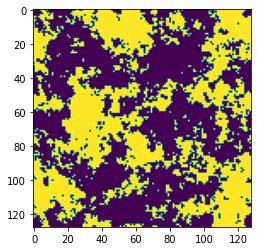

In [18]:
test2d = pattern[-1,:,:]
plt.imshow(test2d)

In [27]:
avg2d = []
avg2d_hm = []

for i in range(len(pattern)):
  slice = pattern[i,:,:]
  slope2d, intercept2d, sz2d, count2d = fractal_dimension_2d(pattern[i,:,:])
  hm2d, count = boxcount2d(boxes, slice)
  avg2d.append(slope2d)
  avg2d_hm.append(hm2d)

slope2d1 = np.mean(avg2d)
slope2d2 = np.mean(avg2d_hm)

print(slope2d1)
print(slope2d2)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.7118372478819586
1.7118372478819588


In [28]:
print(np.min(avg2d))
print(np.min(avg2d_hm))

1.6636739989972413
1.6636739989972416


In [29]:
print(np.max(avg2d))
print(np.max(avg2d_hm))

1.7546060286631955
1.7546060286631948


In [30]:
fractal_dimension_3d(np.asarray(pattern))

(2.8199299021563067,
 13.961804033838497,
 array([64, 32, 16,  8,  4,  2]),
 [8, 64, 512, 4062, 27907, 120687])

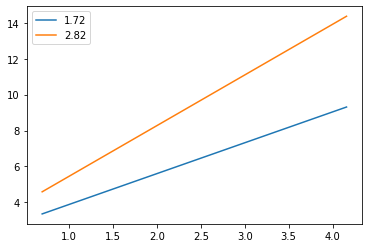

In [31]:
plt.plot(np.log(sz2d), slope2d*np.log(sz2d)+np.log(intercept2d), label=f"{round(slope2d, 2)}")

slope3d, intercept3d, sz3d, count3d = fractal_dimension_3d(np.asarray(pattern))
plt.plot(np.log(sz3d), slope3d*np.log(sz3d)+np.log(intercept3d), label=f"{round(slope3d, 2)}")

leg = plt.legend()
plt.show()